In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/2022/lesson6')

Mounted at /content/drive


## Modelling Correlation between Risks

### Distribution Transformation

* Distribution transformation (also called *inverse transform*, *probability integral transform* or *percentile-to-percentile transform*) is used to transform a random variable PDF to a uniform distribution and vice versa. 
* The key ingredient of this method are:
  * computing the CDF or the quantile function of a distibution;
  * uniform samples can be interpreted as cumulative probabilities (i.e.  CDF$_{\textrm{uniform}}(X)=X$).
    
$$\textrm{uniform_sample} \rightarrow \tt{distribution.ppf(uniform\_sample)} \rightarrow \textrm{distribution_sample}$$
$$\textrm{distribution_sample} \rightarrow \tt{distribution.cdf(distribution\_sample)} \rightarrow \textrm{uniform_sample}$$


#### Example

* $U(X)$ is the uniform distribution: to convert to normal just apply the quantile function (the inverse of the CDF).

In [ ]:
# make table uniform to gauss
from scipy.stats import norm

U = [0.3, 0.5, 0.9, 0.999999999]

for x in U:
  print (x, norm.ppf(x))


0.3 -0.5244005127080409
0.5 0.0
0.9 1.2815515655446004
0.999999999 5.997807019601637


<img src="https://drive.google.com/uc?id=1KVtr2VG_l2jVcfJ6C8Nw6ChSMYyKCo3d" width=600>

* $\tt{python}$ provides an easier way to apply such transformations:
  * Given a distribution class (e.g. uniform, norm,...):
      * `rvs(size=1000)` method samples `size=1000` times from it.
      * methods like `cdf or `ppf` take in input `numpy.array, a particular kind of list, *allowing to avoid loop-cycles*: **the transformation itself is indeed automatically applied to each item of the array.**

In [ ]:
# sample from uniform adnd transform to norm
from scipy.stats import uniform, norm
import numpy as np
import time

N = 10000
x_unif = uniform.rvs(size=N)

# method 1: slower and with more code to write
t1 = time.time()
x = np.empty(N)
for i in range(len(x_unif)):
  x[i] = norm.ppf(x_unif[i])
print (time.time() - t1)

# method 1: x2000 faster using "vectorization"
t2 = time.time()
x = norm.ppf(x_unif)
print(time.time() - t2)

3.8061726093292236
0.0019266605377197266


<img src="https://drive.google.com/uc?id=1hI__fhnbuRSIfghtaq7oxlJuopcVlLqp">

* with a 2D plot we can get a sense of what is going on when using the inverse CDF transformation:

<img src="https://drive.google.com/uc?id=1iGVVqrrPZ_Ag1Kg_PysJzRM0Z5F0MOSp">

* The transformation stretches the outer regions of the uniform to yield a normal distribution. 

* This technique can be used with any arbitrary (univariate) probability distributions, like for example t-Student or Gumbel.

In [ ]:
# do the same with t-student
from scipy.stats import t

x2 = t(4).ppf(x_unif)

<img src="https://drive.google.com/uc?id=1bvn2OmnZz3iLzpq4jQMHqn_aLgRLiSCI">

* To go from an arbitray distribution to uniform, just apply the inverse of the inverse CDF, which is the CDF itself...

In [ ]:
# make uniform to gauss to uniform

x2 = norm.ppf(x_unif)
x3 = norm.cdf(x2)

print (x3[0:5])
print (x_unif[0:5])

[0.64716548 0.06303914 0.73552963 0.66028051 0.0717653 ]
[0.64716548 0.06303914 0.73552963 0.66028051 0.0717653 ]


<img src="https://drive.google.com/uc?id=1oOhLIBIkYdM7qWVek9yHLlgJofo0snnX">

## Copula

* In general **correlation measures the tendency of two or more companies to "influence" their behaviour**. 

* The estimate of default probabilities and their correlations is the most important issue in credit derivative valuation and credit risk management. 

* The estimate through *historical default data* is very inaccurate (low default data availability, inadequacy of data...); so **mathematical models** are used.

* **Copulas** are used to describe dependencies between random variables related with risk. 
  * A copula $\mathcal{C}(F_1, F_2, \ldots, F_n)$ is a multivariate cumulative distribution function whose marginal probability distributions (the probability distribution of each dimension) are uniform. 
  * Very popular since allows to easily model and estimate the distribution of random vectors by representing marginal distributions and their correlation separately: **a complicated problem can be split into simpler components**.

### Example

* Consider the daily returns of BMW and Siemens stocks (2010-2022). 
  * data file in [bmw_siemens.csv](https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/bmw_siemens.csv)

In [ ]:
# read file, create series and corr()
import pandas as pd

data = pd.read_csv("https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/bmw_siemens.csv", index_col="Date")

bmw = data.loc[:, 'BMW.DE']
sie = data.loc[:, 'SIE.DE']

print (data[['BMW.DE', 'SIE.DE']].corr())

          BMW.DE    SIE.DE
BMW.DE  1.000000  0.664654
SIE.DE  0.664654  1.000000


<center>

![](https://drive.google.com/uc?id=1KHj_X_BgOqxtxG3JkkFpj_Ct2b2onM32)

</center>

* **It's reasonable to assume that the two returns are correlated**:
  * same country and similar sector.

* Imagine you want to model the joint distribution of their returns to know what is the probability both shares goes negative at the same time.

* With **copulas** can decompose a joint probability distribution into  marginals (which by definition have no correlation) and a function which *couples* them together.

* By fitting the histograms we can determine the marginal distributions (t-student).

<center>

![](https://drive.google.com/uc?id=1M8VMupUEup_nK_B5fuVZdrzc2tNGNdd6)

![](https://drive.google.com/uc?id=1PtCf5wQBetPP1C7qcVKYElFM8_MLPyyy)

</center>



#### Modelling Correlation with Copulas

* Sample from a **multivariate normal** (2D) with a 0.66 correlation
  * The covariance between random variables (the returns) can be expressed with the matrix:

$$
\Sigma = \begin{bmatrix}
\sigma^2 (X_0) & \mathrm{Cov}(X_0, X_1)\\
 \mathrm{Cov}(X_1, X_0) & \sigma^2 (X_1)
\end{bmatrix}
$$

In [ ]:
# sample from multi-normal with corr
from scipy.stats import multivariate_normal
import numpy as np

np.random.seed(1)
N = 1000000
mv = multivariate_normal(mean=[0,0], cov=data[['BMW.DE', 'SIE.DE']].corr())
x = mv.rvs(size=N)

print (x[:10])

[[-1.23142095 -1.73242345]
 [ 0.92121932  0.04250362]
 [ 0.1529028  -1.73195958]
 [-1.28012801 -1.90352412]
 [-0.18895377 -0.39317751]
 [-0.49032596 -2.17749365]
 [ 0.45140965  0.13688545]
 [-0.58397804 -1.48474225]
 [ 0.51677401 -0.20215473]
 [-0.27716288  0.20013802]]


In [ ]:
z = np.loadtxt('https://raw.githubusercontent.com/matteosan1/finance_course/develop/libro/input_files/multivariate_normal_uncorr.csv', delimiter=',')

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Multivariate Normal w/o correlation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import plotly.graph_objects as go
import numpy as np

x, y = (np.arange(-4, 4, .01), np.arange(-4, 4, .01))
z = np.loadtxt('https://raw.githubusercontent.com/matteosan1/finance_course/develop/libro/input_files/multivariate_normal_corr.csv', delimiter=',')

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Multivariate Normal w/ correlation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

<center>

![](https://drive.google.com/uc?id=1KZ9mXhgXM_sTauo5aFMj5ZWcfRipnvzB)

</center>

* Now tranform the marginals to uniform using the `cdf` method. 

In [ ]:
# convert each component
from scipy.stats import norm

copula = norm.cdf(x)
print (copula[:10])

[[0.10908273 0.0415991 ]
 [0.82153203 0.51695139]
 [0.56076254 0.04164038]
 [0.10025006 0.02848609]
 [0.42506453 0.34709419]
 [0.31195163 0.01472188]
 [0.67415284 0.55443933]
 [0.27961754 0.06880606]
 [0.69734304 0.41989788]
 [0.39082752 0.57931368]]


<table>
    <tr>
        <td><img src="https://drive.google.com/uc?id=1gjR0tfDGUx20Edz7XcV3ViArW6Yr-Bvq" width=500></td>
        <td><img src="https://drive.google.com/uc?id=1ATeUMB9p2tjJoqLplxddnB-K4XUJ3xIm" width=500></td>
    </tr>
</table>

* **Since we used a multivariate stadard normal to model correlation this is also called a Gaussian Copula.**

* Finally we can just transform the marginals from uniform to what we want (i.e. the two t-students in our example): 

In [ ]:
# fit and create distributions
from scipy.stats import t

bmw_fit = t.fit(bmw[1:])
sie_fit = t.fit(sie[1:])

bmw_f = t(*bmw_fit)
sie_f = t(df=sie_fit[0], loc=sie_fit[1], scale=sie_fit[2])

In [ ]:
# convert uniform marginals with fitted functions

bmw_corr = bmw_f.ppf(copula[:, 0])
sie_corr = sie_f.ppf(copula[:, 1])

* Now that we have a model for the joint distribution of the two share returns we can compute the probability to have both of them negative.


In [ ]:
# compute fraction of bad events
n = 0 
for i in range(len(bmw_corr)):
  if bmw_corr[i] < 0 and sie_corr[i] < 0:
    n += 1

print (n/N)

0.353726


* As a comparison we can calculate the same probability ignoring the correlation between the returns.
  * Just sample from the to marginals and count whether they both are negative or not.

In [ ]:
# create fraction of bad events from uncorrelated
bmw_uncorr = bmw_f.rvs(size=100000)
sie_uncorr = sie_f.rvs(size=100000)

n = 0 
for i in range(len(bmw_uncorr)):
  if bmw_uncorr[i] < 0 and sie_uncorr[i] < 0:
    n += 1

print (n/N)

0.023536


<table>
    <tr>
        <td><img src="https://drive.google.com/uc?id=1PtCf5wQBetPP1C7qcVKYElFM8_MLPyyy" width=500></td>
        <td><img src="https://drive.google.com/uc?id=1FtxyUSjz6Wy9mUiX0FrPaRrI0lq2auHe" width=500></td>
    </tr>
</table>


### Remarks

* *“Extreme, synchronized rises and falls in financial markets occur
infrequently but they do occur. The problem with the models is that
they did not assign a high enough chance of occurrence to the scenario
in which many things go wrong at the same time the “perfect storm” scenario”*.

![](https://drive.google.com/uc?id=1J9Ol13mytPqhwF2mpAAWGYvsZh8Zxktc)


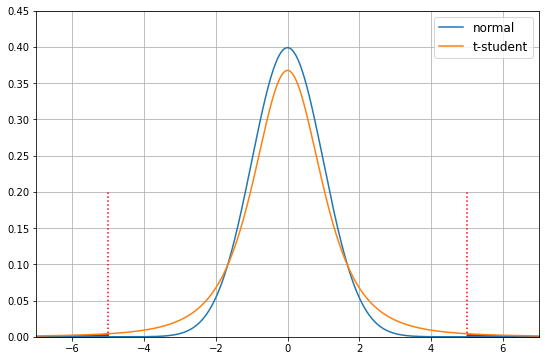

In [ ]:
import numpy as np
from scipy.stats import norm, t
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (9, 6)
x = np.arange(-10, 10, 0.01)
xleft = np.arange(-10, -5, 0.01)
xright = np.arange(5, 10, 0.01)
plt.plot(x, norm.pdf(x), label='normal')
plt.plot(x, t(3, 0, 1).pdf(x), label='t-student')
plt.vlines(-5, 0, 0.20, color='red', linestyle=':')
plt.vlines(5, 0, 0.20, color='red', linestyle=':')
plt.fill_between(xleft, t(3, 0, 1).pdf(xleft), color='red')
plt.fill_between(xright, t(3, 0, 1).pdf(xright), color='red')
plt.grid(True)
plt.xlim(-7, 7)
plt.ylim(0, 0.45)
plt.legend(fontsize=12)
plt.show()

In [ ]:
from scipy.stats import norm

freq = 1/(norm.cdf(-5)*2)/365
print ("Once every {:.0f} years".format(freq))

Once every 4779 years


In [ ]:
from scipy.stats import t

freq = 1/(t(3, 0, 1).cdf(-5)*2)/12
print ("Once every {:.1f} months".format(freq))

Once every 5.4 months


<center>

![](https://drive.google.com/uc?id=1i5lrTkLyW45F-5ylakvijUj_5F4ZRmm9)

</center>

* Gaussian copula is nice and easy to construct but tends to underestimate events on the tails. So it is often used the **t-student copula** which has fatter tails but preserves the same (bell shaped, non-skewed) characteristics of the Gaussian.

<table>
    <tr>
        <td><img src="https://drive.google.com/uc?id=1rARyDX0KFcLJ5riOmzGMFSJ7mW9TqG_K" width=500></td>
        <td><img src="https://drive.google.com/uc?id=1kXN1ulCocg_JxIVBOec0gf61WHtcg90O" width=500></td>
    </tr>
</table>


## Basket Default Swaps
* A basket default swap (BDS) is a credit derivative on a portfolio of n reference entities:
    * the simplest basket default swaps are first-to-default, second-to-default...nth-to-default swaps. 


* Very similar to normal CDS except for the protection they offer:
    * a first-to-default swap provides insurance for only the first default happening;
    * a second-to-default swap provides insurance for only the second default...
    

* For example, in a nth-to-default swap, the seller does not make any payment to the protection buyer for the first $n-1$ defaulted entities, and makes it only for the
$n^{th}$ default. Once there has been this payment the swap terminates.


### n$^{th}$-to-default Basket Valuation 

* Assume the principals and expected recovery rates are the same for all underlying reference assets, also all the assets have the same default probability.

* The valuation procedure is similar to that for a regular CDS:
    * in CDS depends on $P_d$ of the reference asset between times $t_1$ and $t_2$. 
    * in BDS depends on $P_d$ that the $n^{th}$ asset default was between times $t_1$ and $t_2$.

* The buyer of protection makes quarterly payments at a specified rate until the $n^{th}$ default occurs or the end of the life of the contract is reached. 


* In the event of the $n^{th}$ default occurring, the seller pays $F\cdot(1-R)$.


## Inheritance

* Let’s say you have a *base* class $\texttt{Swap}$ and you derive from it to create a $\texttt{InterestRateSwap}$ class. 
* The inheritance relationship states that a $\texttt{InterestRateSwap}$ is an $\texttt{Swap}$. 
  * $\texttt{InterestRateSwap}$ inherits the interface and implementation of $\texttt{Swap}$, and $\texttt{InterestRateSwap}$ objects can be used to replace $\texttt{Swap}$ objects in the application.

* Reuse already written code, keep code more structured and simple.

In [ ]:
from finmarkets import generate_dates

class Swap:
  def __init__(self, start_date, notional, rate_l1, rate_l2, 
               tenor_months_l1, tenor_months_l2, maturity_years):
    self.notional = notional
    self.rate_l1 = rate_l1
    self.rate_l2 = rate_l2
    self.dates_l1 = generate_dates(start_date, 12 * maturity_years, tenor_months_l1)
    self.dates_l2 = generate_dates(start_date, 12 * maturity_years, tenor_months_l2)

  def npv_l1(self, dc):
    val = 0
    for j in range(1, len(self.dates_l1)):
      F = self.rate_l1.forward_rate(self.dates_l1[j], self.dates_l1[j-1])
      tau = (self.dates_l1[j] - self.dates_l1[j-1]).days / 360
      P = dc.df(self.dates_l1[j])
      val += F * tau * P
    return val

  def npv_l2(self, dc):
    val = 0
    for i in range(1, len(self.dates_l2)):
      tau = (self.dates_l2[i] - self.dates_2[i - 1]).days / 360
      val += dc.df(self.dates_l2[i]) * tau
    return self.notional * self.rate_l2 * val

  def npv(self, dc):
    return self.npv_l1(dc) - self.npv_l2(dc)

class OvernightIndexSwap(Swap):
  def npv_l1(self, dc):
    return self.notional * (dc.df(self.dates_l1[0]) - dc.df(self.dates_l1[-1]))

class InterestRateSwap(Swap):
  def annuity(self, dc):
    a = 0
    for i in range(1, len(self.dates_l2)):
      a += dc.df(self.dates_l1[i])
    return a

  def swap_rate(self, dc):
    num = self.npv_l1(dc)
    return num / self.annuity(dc)

  def npv(self, dc):
    S = self.swap_rate(dc)
    A = self.annuity(dc)
    return self.notional * (S - self.rate_l2) * A

* All this to say that below I have created the $\texttt{ExpDefault}$ class to represent the default probability PDF
$$1-e^{-\lambda\cdot t}$$
* This class inherits from $\texttt{rv_continuous}$ which is the base class for implementing distributions in $\texttt{scipy.stats}$.

In [ ]:
from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
import numpy as np

class ExpDefault(rv_continuous): 
  def __init__(self, l):
    super().__init__()
    self.ulim = 100
    self.l = l
    self.ppf_func = self.prepare_ppf()

  def _cdf(self, x):
    x[x < 0] = 0
    return (1 - np.exp(-self.l*x))

  def _pdf(self, x):
    x[x < 0] = 0
    return self.l*np.exp(-self.l*x)

  def _ppf(self, x):
    return self.ppf_func(x)
  
  def prepare_ppf(self):
    xs = np.linspace(0, self.ulim, 10000001)
    cdf = self.cdf(xs)/self.cdf(xs[-1])
    func_ppf = interp1d(cdf, xs, fill_value='extrapolate')
    return func_ppf

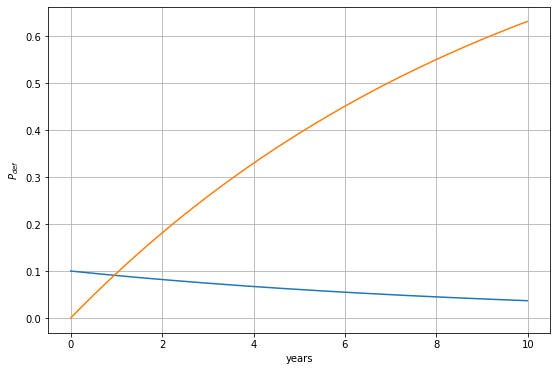

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

l = 0.10

dp = ExpDefault(l) 

x = np.arange(0, 10, 0.01)

plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(x, dp.pdf(x))
plt.plot(x, dp.cdf(x))
plt.xlabel("years")
plt.ylabel(r"$P_{def}$")
plt.grid(True)
plt.show()

### Algorithm to Valuate a BDS

* **The code assumes same default probability for each entity and Gaussian correlation but it can be generalized quite easily**.

1. Create a copula as outlined above;
2. sample $N$ times from it and transform each component to the desired default distributions (now we have a sample of default times for each company in $N$ scenarios);
4. counts how many defaults have been simulated at some discrete times to compute the correlated default probability;
5. with those probabilities construct the credit curve;
6. valuate a standard CDS with the just determined credit curve. 


In [ ]:
from finmarkets import CreditCurve, CreditDefaultSwap
from scipy.stats import norm
import numpy as np
from scipy.stats import multivariate_normal, norm

class BasketDefaultSwaps:
  def __init__(self, nominal, start_date, spread, maturity, 
               hazard_rate, rho, N,
               tenor=3, recovery=0.4):
    self.cds = CreditDefaultSwap(nominal, start_date, spread, maturity, tenor, recovery)
    self.Q = ExpDefault(l=hazard_rate)
    self.N = N
    self.rho = rho
    self.cc = None

  def credit_curve(self, pillars, n_defaults):
    simulations = 100000
    cov = np.ones(shape=(self.N, self.N))*self.rho
    np.fill_diagonal(cov, 1)
    mean = np.zeros(self.N)
    mv = multivariate_normal(mean=mean, cov=cov)
    x = mv.rvs(size=simulations)
    x_unif = norm.cdf(x)
    default_times = self.Q.ppf(x_unif)

    Ts = [(p-pillars[0]).days/360 for p in pillars]
    ndps = []
    for t in Ts:
      b = np.count_nonzero(default_times<=t, axis=1)
      ndps.append(1 - len(b[b>=n_defaults])/simulations)
    self.cc = CreditCurve(pillars, ndps)

  def npv(self, dc):
    if self.cc is None:
      print ("Need to call credit_curve method first !")
      return None
    return self.cds.npv(dc, self.cc)
  
  def breakeven(self, dc):
    return self.cds.breakevenRate(dc, self.cc)

* Consider a 2-years 3rd-to-default BDS on 10 reference entities with a Gaussian copula correlation of 0.3. The expected recovery rate, $R$, is $40\%$ and spread of the contract is 0.01. The term structure of interest rates is assumed to be flat at 5%. 

* The default probabilities for the 10 entities are generated by Poisson processes with constant hazard rates, $\lambda_i = 0.01$, so that 

$$Q(t) = 1 - e^{-\lambda t} $$

In [ ]:
from finmarkets import DiscountCurve, CreditCurve
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np

n_cds = 10
rho = 0.3
l = 0.06
pricing_date = date.today()
pillar_dates = [pricing_date + relativedelta(years=i) for i in range(6)]
dfs = [1/(1+0.05)**i for i in range(6)]
dc = DiscountCurve(pillar_dates, dfs)

basket = BasketDefaultSwaps(1, pricing_date, 0.01, 2, l, rho, n_cds)
basket.credit_curve(pillar_dates, 3)
print (basket.npv(dc))

0.019585748656683957


<center>

![](https://drive.google.com/uc?id=1gBRWLhky2DZ-Zm9-NgmC1wSGnEr5jbaA)

</center>